# **A bit of software architecture and how to create clear and maintainable code**

> Today we will create smallest recommendation system for articles.

Before starting to design the program, we need to formulate what we want from the programы

We will have 2 actors: 
- authors who publish articles
- users who want to read some articles (and our task is to recommend articles suitable for them).

### **User Stories**

DISCLAIMER: We make a toy API, not a full-fledged client API, i.e. the functionality that our API provides is rather some API for platform admins, who can both create articles and debug what is shown to users

**User stories**
<details>
<summary> Author surface</summary>

1. As an author, I want to create new articles

2. As an author, I want to see all my articles

3. As an author, I want to see how many users have read my article or some other feedback (maybe some statistics) (As AdHoc)
</details>


<details>
<summary> User surface</summary>

1. As a user, I want to be able to register (simple user creation)

2. As a user, I want to get articles that are right for me

3. As a user, I want to leave some feedback on articles (like, dislike) (As AdHoc)

4. As a user, I want to leave comments on articles (As AdHoc)
</details>


### **Domain Model**

When we defined our goals, lets define entities and interactions between them

The first iteration, we divide the code into the data part and the part responsible for logic. We will also highlight the code responsible for working with embeddings in a separate service.

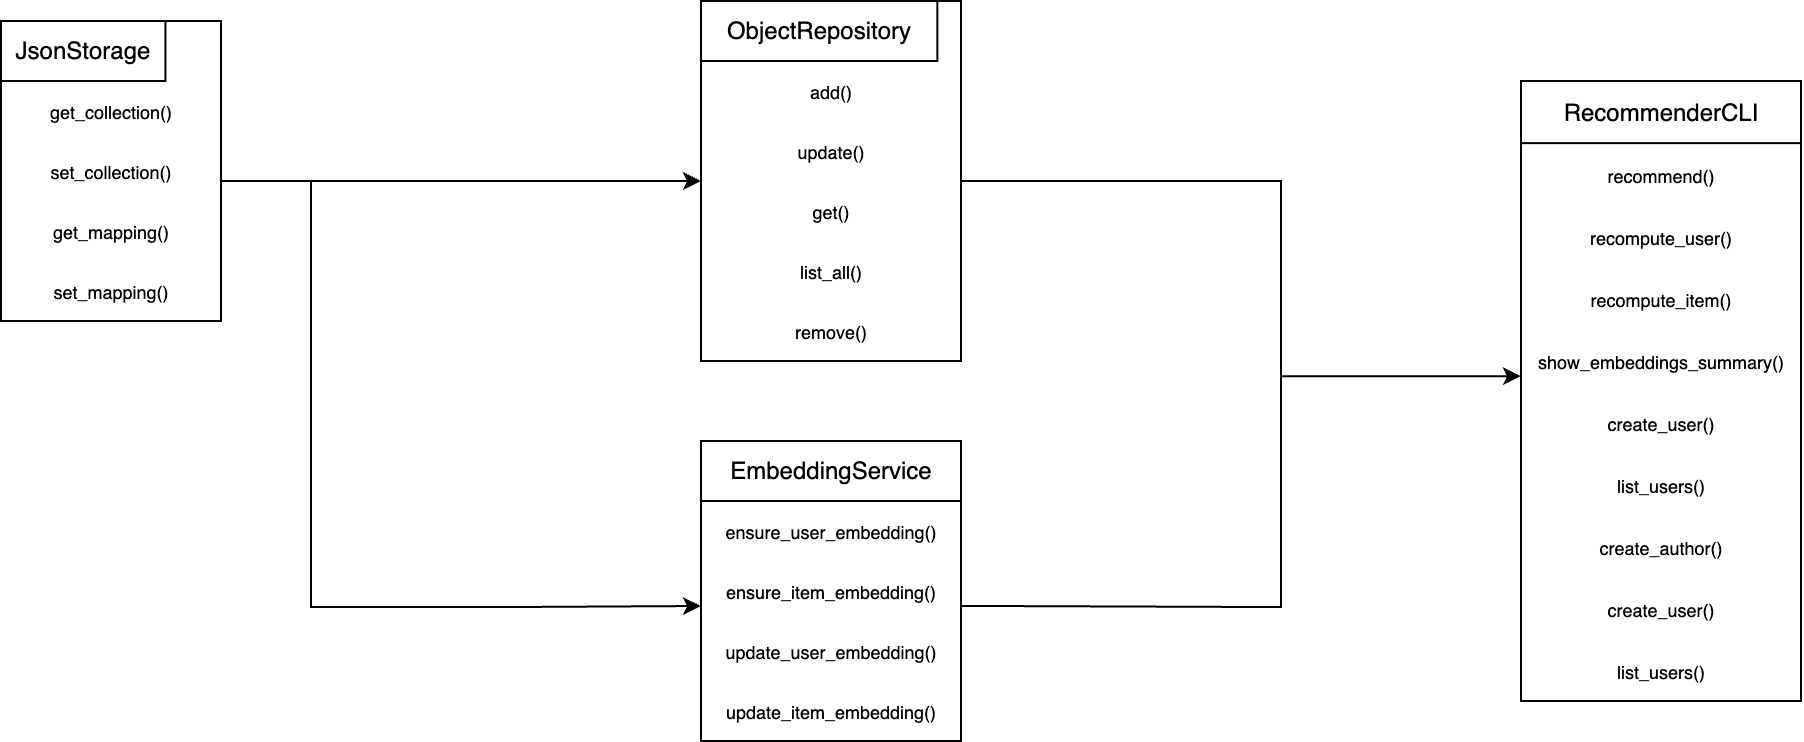

Note that RecommenderCLI performs UI and business logic functionality at once.  Let's separate the UI component into separate controllers

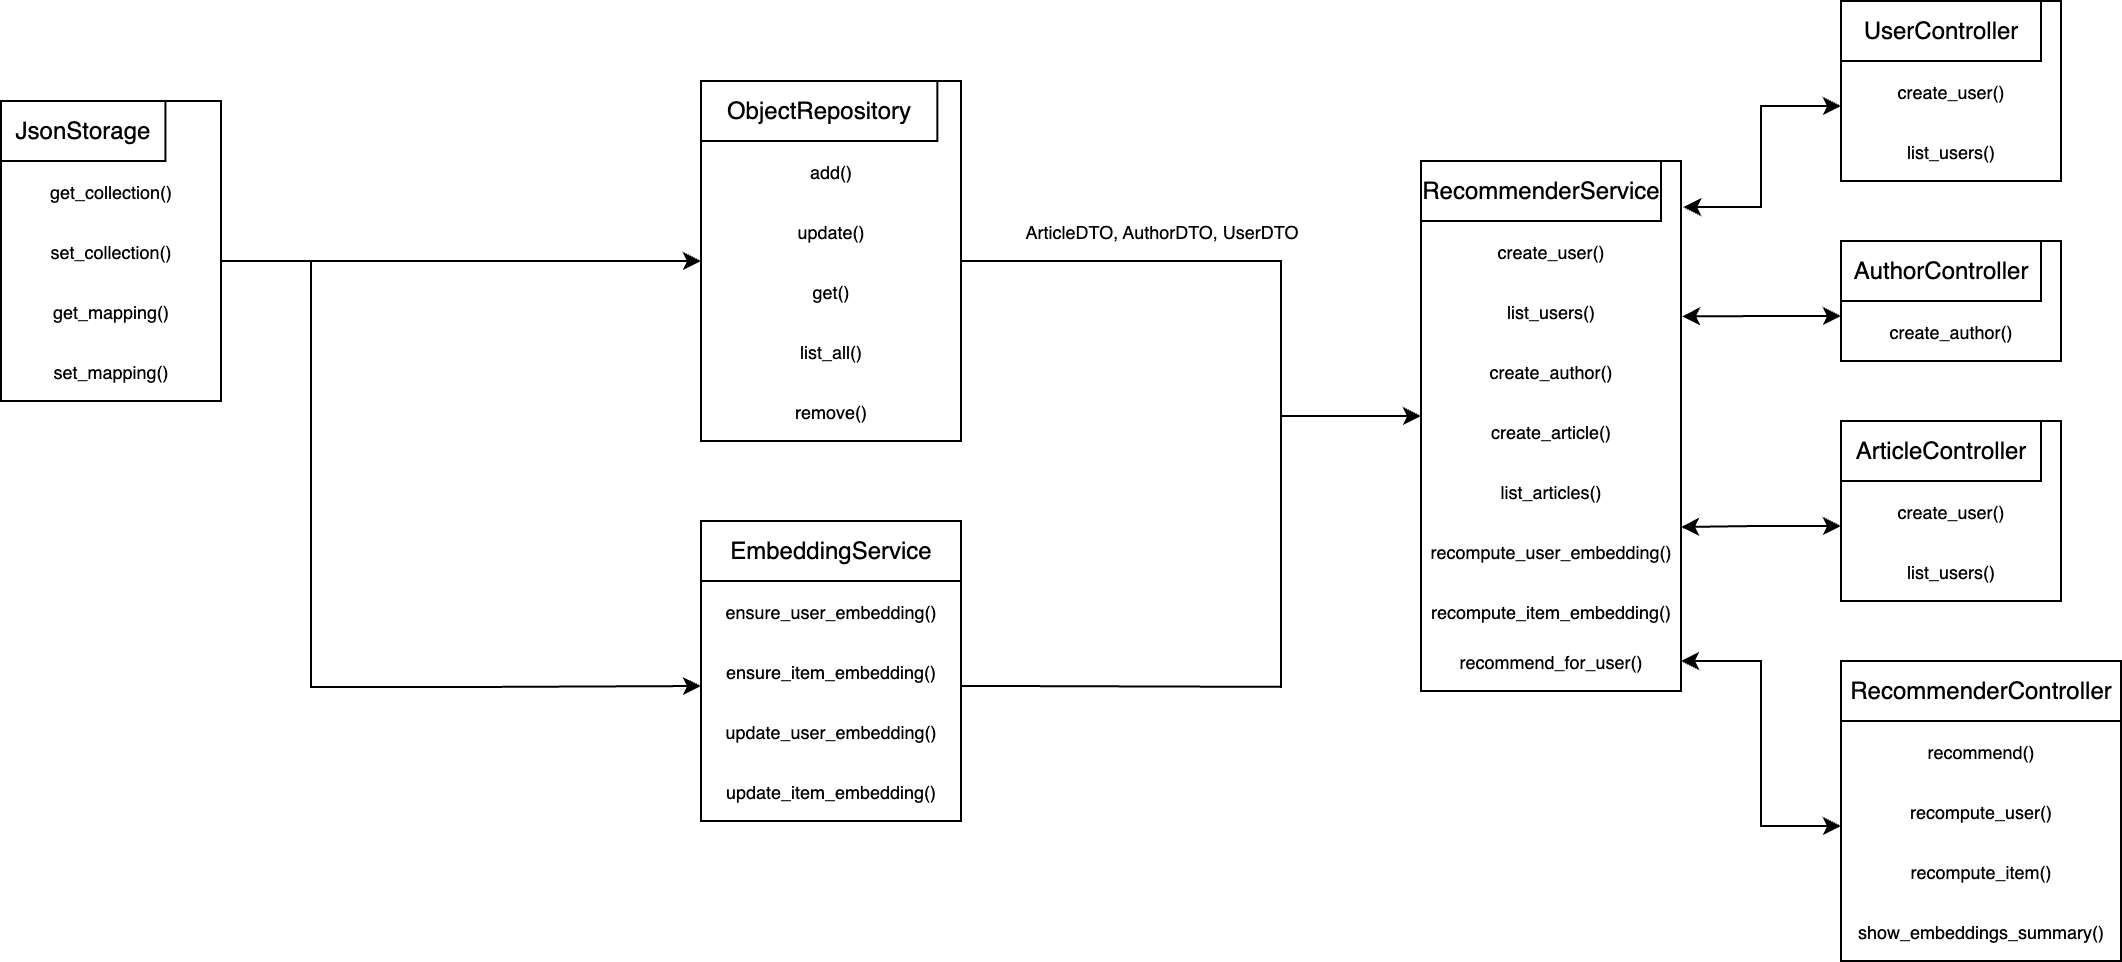

Now let's note that we have one repository for all objects, which violates several SOLID principles at once and makes it difficult to maintain, so we'll split the data logic between separate repository classes.

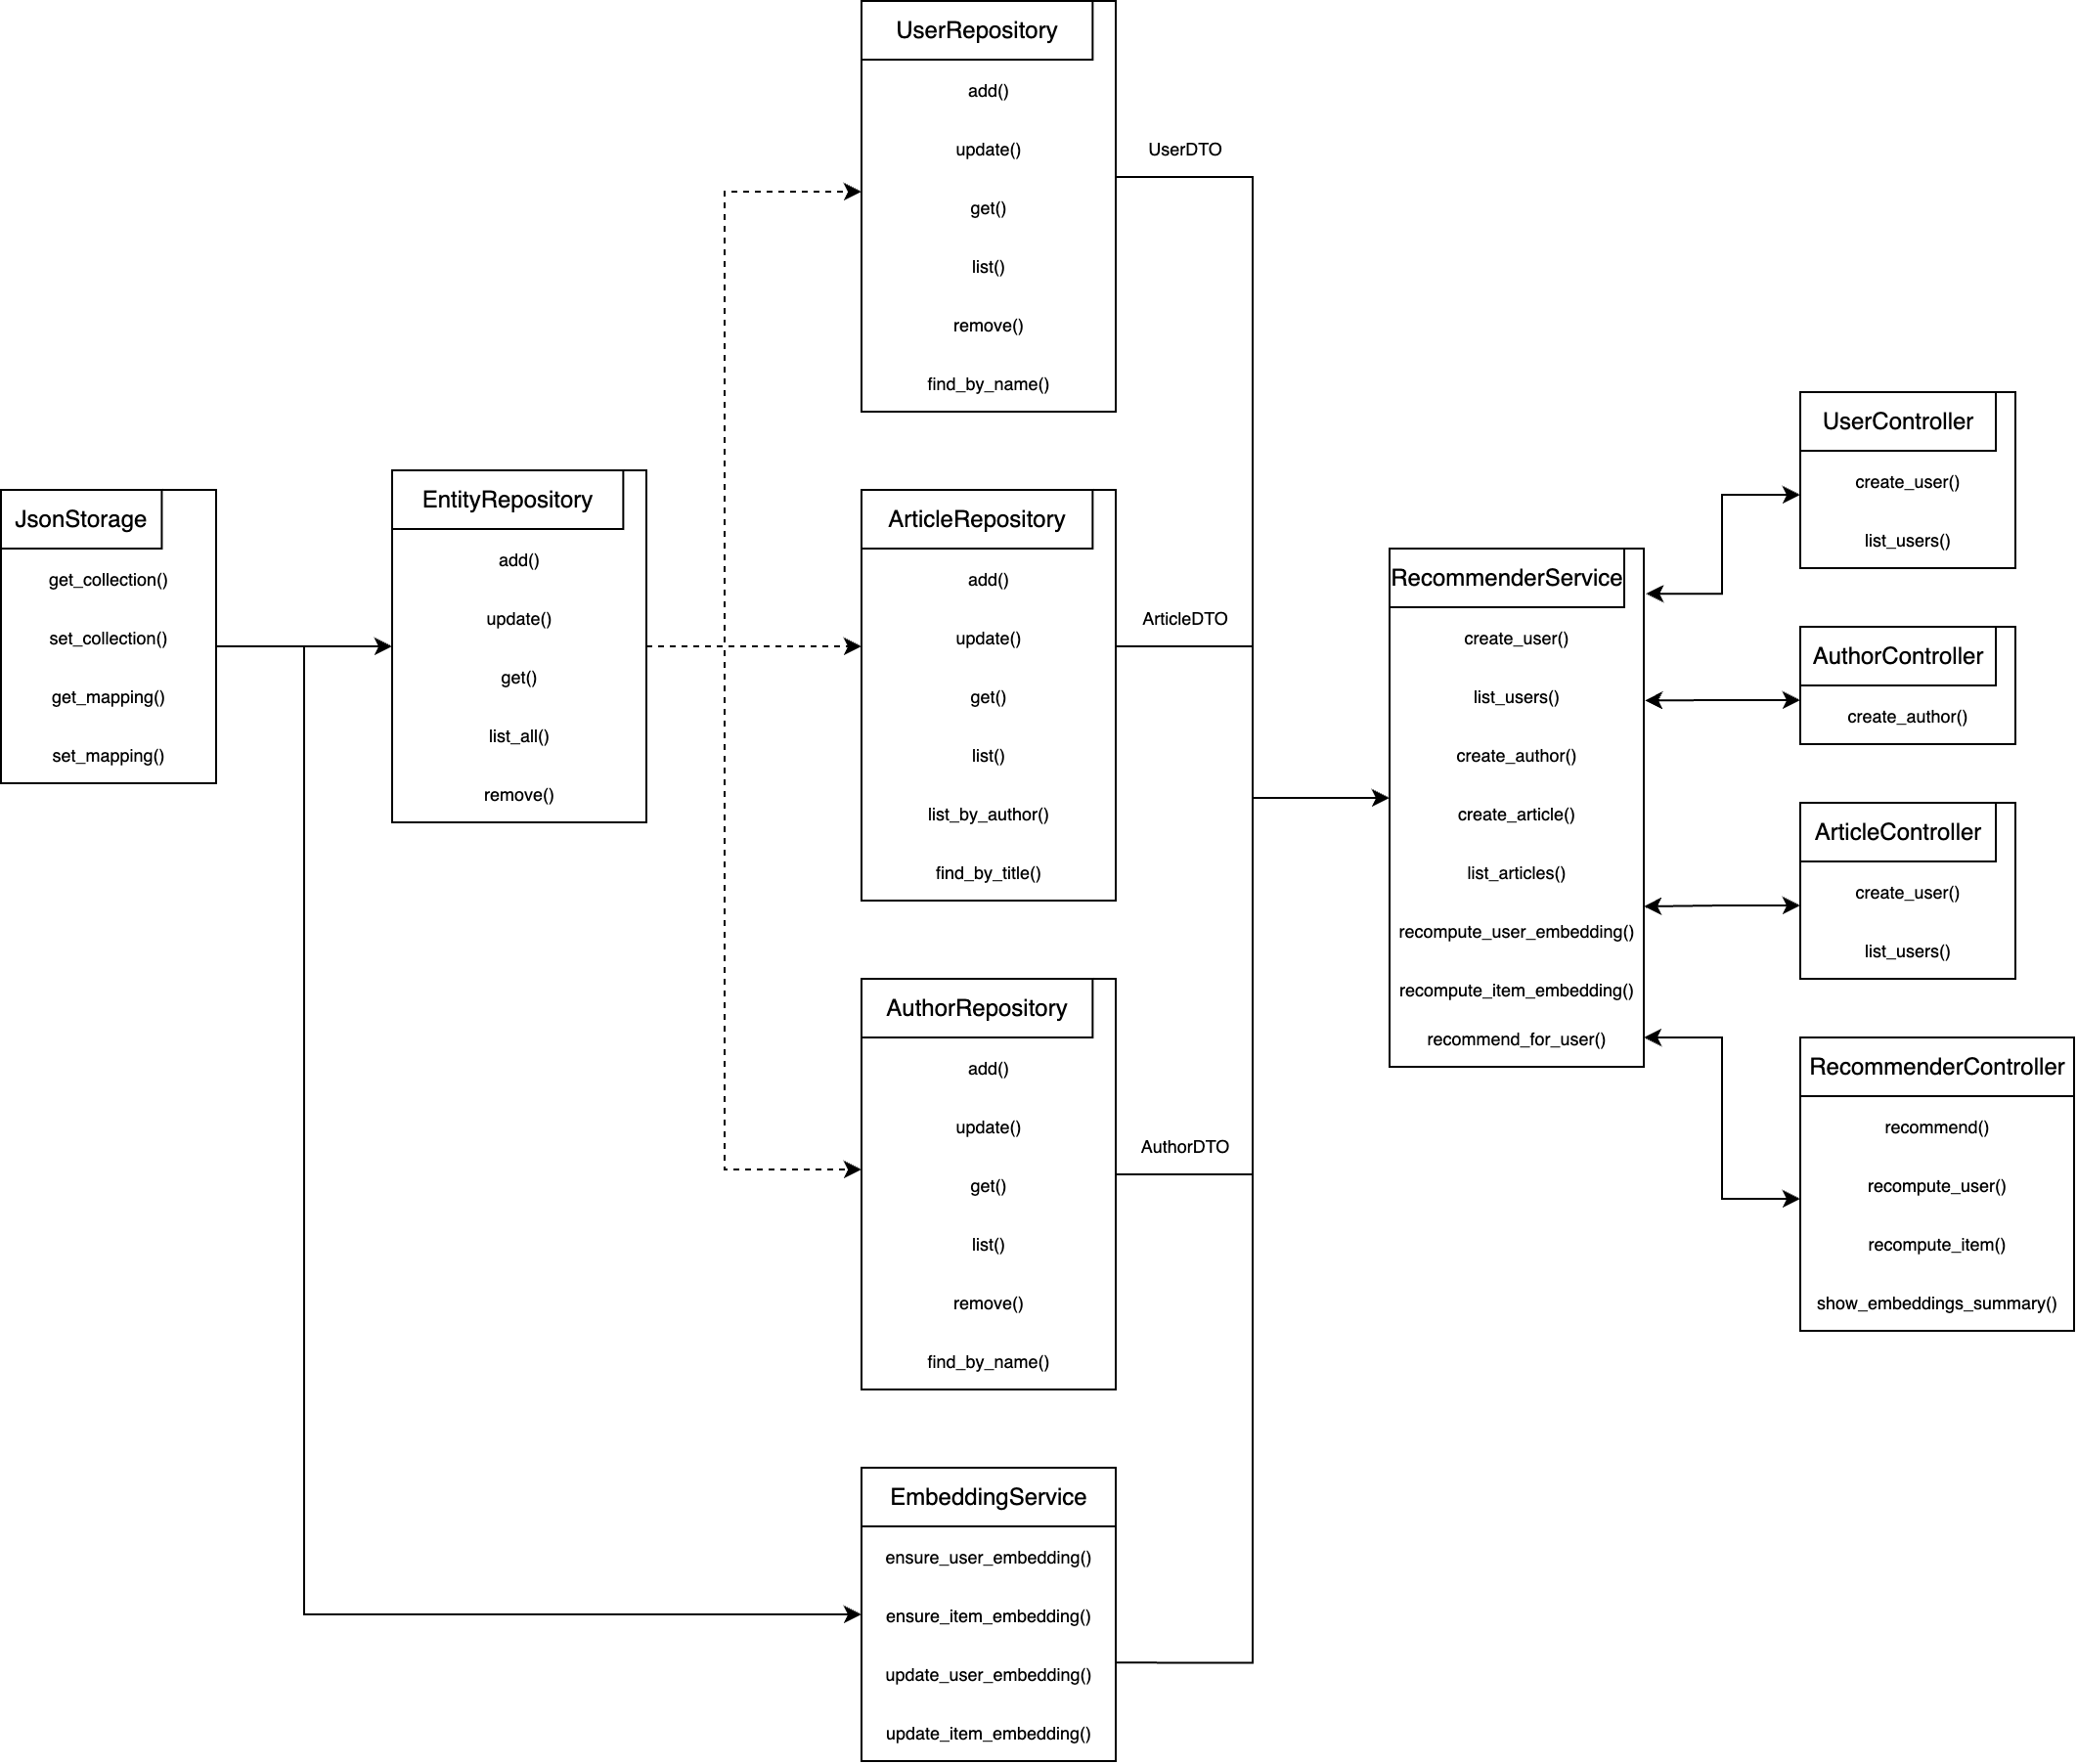

Note that json based storage may not be optimal for embeddings, and storing and working with embeddings in the same code violates SOLID. Let's create separate Repositories for embeddings and create another numpy-based DB.

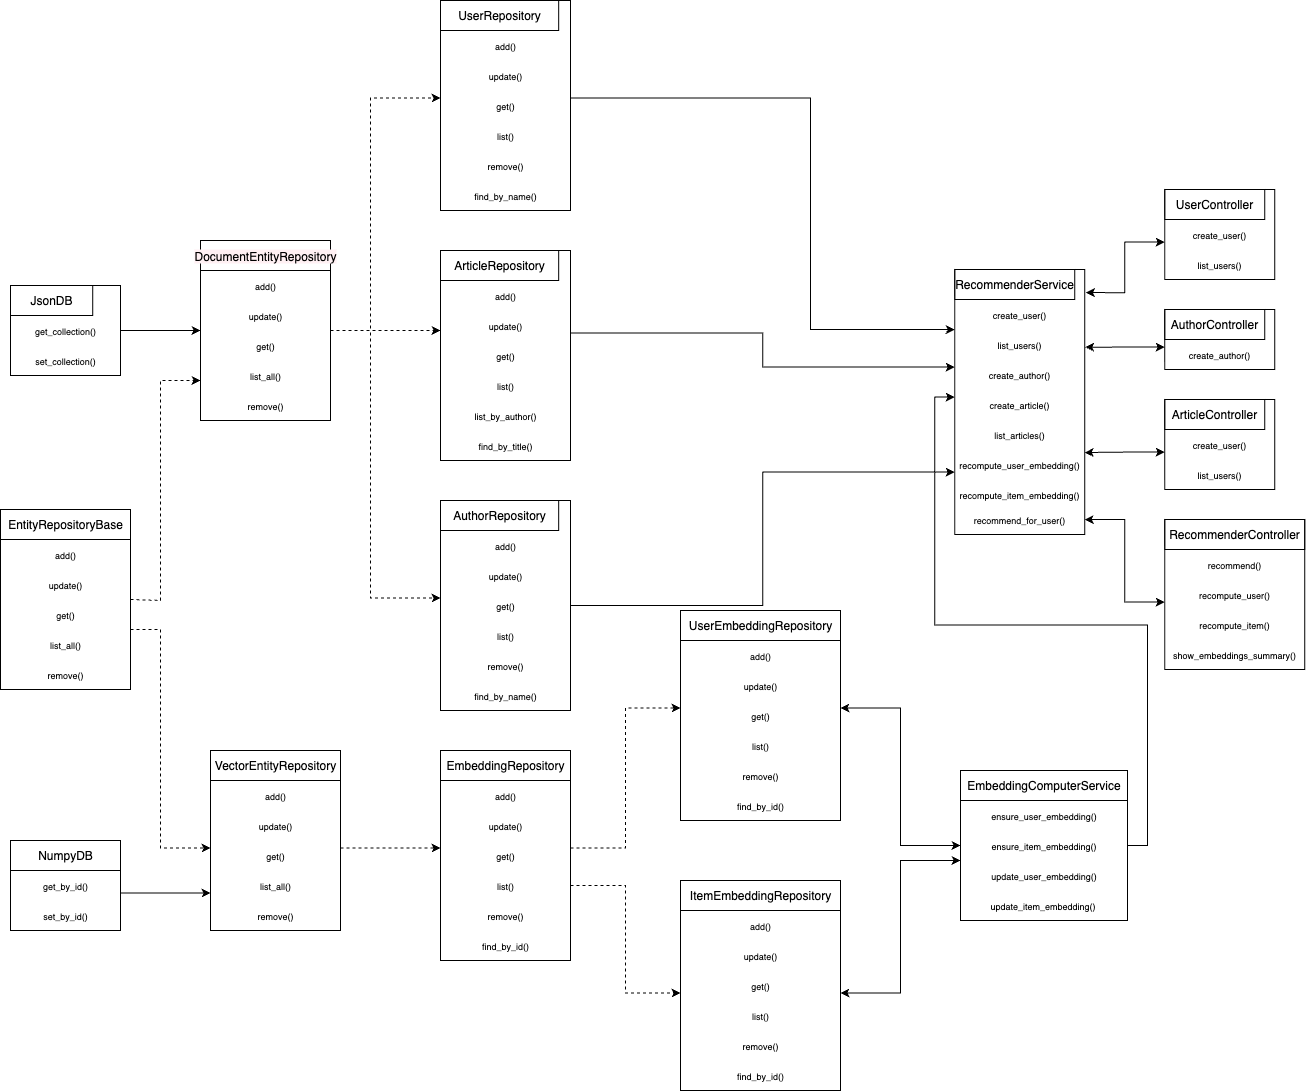

In [1]:
from src.infrastructure.repository.author_repository import AuthorRepository
from src.infrastructure.repository.user_repository import UserRepository
from src.infrastructure.repository.article_repository import ArticleRepository
from src.infrastructure.repository.embedding_repository import EmbeddingRepository
from src.services.recommender_service import RecommenderService
from src.services.embedding_computer_service import EmbeddingComputerService
from src.services.dto.dtos import ArticleDTO, UserDTO

from src.infrastructure.db.json_db import JsonDB
from src.infrastructure.db.numpy_db import NumpyDB
jsonDB = JsonDB("data/db.json")
numpyDB = NumpyDB("data/npy")

In [2]:
author_repository = AuthorRepository(jsonDB)
user_repository = UserRepository(jsonDB)
article_repository = ArticleRepository(jsonDB)

user_embedding_repository = EmbeddingRepository(numpyDB)
article_embedding_repository = EmbeddingRepository(numpyDB)

In [3]:
embedding_computer_service = EmbeddingComputerService(
    user_embedding_repository, 
    article_embedding_repository, 
    embedding_dim=128)

recommender_service = RecommenderService(
    user_repository, 
    author_repository,
    article_repository,
    user_embedding_repository,
    article_embedding_repository,
    embedding_computer_service)

In [ ]:
recommender_service.create_article(
    ArticleDTO(1, "Harry Potter", 1)
)
recommender_service.list_articles()

[ArticleDBO(id=1, title='Harry Potter', author_id=1)]

## Pytest

> Pytest is a Python-based unit testing framework that provides test discovery, execution, and reporting functionalities. It allows the definition of test cases as functions, classes, or methods following naming conventions, and supports advanced features such as fixtures, parameterized testing, and plugin-based extensibility.

### Why we need Pytest?
* **Hidden regressions**  
    - <span style="color:red">**Without pytest:**</span> Adding new features can unintentionally break existing code without you noticing.  
    - <span style="color:green">**With pytest:**</span> Automated test suites run every time, catching regressions immediately.  

* **Manual testing fatigue**  
    - <span style="color:red">**Without pytest:**</span> You must recheck functionality by hand after every change — slow and error-prone.  
    - <span style="color:green">**With pytest:**</span> All tests run automatically with one command, giving instant feedback.  

* **Inconsistent validation**  
    - <span style="color:red">**Without pytest:**</span> Developers might test in different ways or forget edge cases.  
    - <span style="color:green">**With pytest:**</span> Shared, reproducible tests ensure consistent behavior across environments.  

* **Harder refactoring**  
    - <span style="color:red">**Without pytest:**</span> You hesitate to improve code structure because you might break something.  
    - <span style="color:green">**With pytest:**</span> Tests act as a safety net, verifying that refactoring doesn’t alter expected outcomes.  

### First pytest example

In [3]:
! pip install -q pytest pytest-cov pytest-mock
! mkdir tests

When you run pytest, it scans your project directory recursively and looks for:
*   Files named `test_*.py` or `*_test.py`
    Inside those files:
    -   Functions named `test_*` (regular functions)
    -   Classes named `Test*` (without `__init__`)
    -   Inside classes, methods named `test_*`

In [5]:
%%writefile src/mathops.py
def add(a, b):
    return a + b

def div(a, b):
    if b == 0:
        raise ZeroDivisionError("Division by zero!")
    return a / b

Overwriting src/mathops.py


Let's add some tests

In [ ]:
%%writefile tests/test_discovery.py
from src.mathops import add

def test_add_basic():
    assert add(2, 3) == 5

# for defining test cases you can use both function and class methods 
# (for example if you want to share some state between tests)
class TestMath:
    def test_add_negative(self):
        assert add(-1, -2) == -3

Writing tests/test_discovery.py


In [13]:
%%writefile pytest.ini
[pytest]
pythonpath = src
testpaths = tests

Overwriting pytest.ini


In [31]:
!pytest -q

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
..                                                                       [100%]
2 passed in 0.00s


### Fixtures and DI [dependency injection]

A fixture in pytest is a reusable provider of test data, connections, or setup/teardown logic.

When you name a parameter in a test function (or method), pytest looks for a fixture with the same name and injects it automatically.

Fixtures can have different scopes:
| Scope    | When created                     | When destroyed                          | Example use                              |
|-----------|----------------------------------|------------------------------------------|-------------------------------------------|
| function  | before every test                | after that test                          | temporary files, per-test setup           |
| class     | once per test class              | after all methods                        | test classes with shared data             |
| module    | once per file                    | after all tests in file                  | reuse expensive setup                     |
| package   | once per test package| after all tests in that package          | rarely used                              |
| session   | once per full run                | at the end of testing                    | DB connections, global setup              |


In [32]:
%%writefile tests/test_scopes.py
import pytest

@pytest.fixture(scope="function")
def f_scope():
    print("Setup: function")
    yield
    print("Teardown: function")

@pytest.fixture(scope="module")
def m_scope():
    print("Setup: module")
    yield
    print("Teardown: module")

@pytest.fixture(scope="session")
def s_scope():
    print("Setup: session")
    yield
    print("Teardown: session")

def test_one(f_scope, m_scope, s_scope):
    print("Running test_one")

def test_two(f_scope, m_scope, s_scope):
    print("Running test_two")


Writing tests/test_scopes.py


In [35]:
!pytest -s -q tests/test_scopes.py 

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Setup: session
Setup: module
Setup: function
Running test_one
.Teardown: function
Setup: function
Running test_two
.Teardown: function
Teardown: module
Teardown: session

2 passed in 0.00s


Normally, you must name the fixture in your test parameters for it to be used.
`autouse=True` makes pytest automatically use that fixture for every test in its scope — even if you don’t mention it.

<div class="alert alert-info">
<b>Hint:</b>
    That’s helpful for things like logging, environment setup, or temporary directories.
</div>

Autouse fixtures still respect scope:
* scope="function" → runs before and after every test
* scope="module" → runs once for all tests in that module
* scope="session" → runs once for the whole run

In [42]:
%%writefile tests/test_autouse.py
import pytest

events = []

@pytest.fixture(autouse=True, scope="function")
def before_each():
    events.append("setup")
    yield
    events.append("teardown")

def test_a():
    events.append("A")

def test_b():
    events.append("B")

def test_result():
    # check the pattern
    assert events == ['setup', 'A', 'teardown', 'setup', 'B', 'teardown', 'setup']
    

Overwriting tests/test_autouse.py


In [43]:
!pytest -q -s tests/test_autouse.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
...
3 passed in 0.00s


### Parametrized Tests

`@pytest.mark.parametrize` lets you run one test function with multiple sets of arguments — extremely useful for covering many input/output cases.

In [45]:
import pytest
@pytest.mark.parametrize(
#The first argument "a,b,expected" is a comma-separated list of parameter names.
    "a,b,expected", 
#The second argument is a list of tuples — each tuple corresponds to one test case.
    [
        (1, 2, 3),
        (5, 10, 15),
    ],
#You can use ids=[...] to name cases for readable output.
    ids=["pos+pos", "neg+neg", "big+zero"]
)
def test_add(a, b, expected):
    assert add(a, b) == expected

In [48]:
%%writefile tests/test_param_basic.py
import pytest
from mathops import add

@pytest.mark.parametrize(
    "a,b,expected",
    [
        (1, 2, 3),
        (-1, -1, -2),
        (100, 0, 100)
    ],
    ids=["pos+pos", "neg+neg", "big+zero"]
)
def test_add_cases(a, b, expected):
    assert add(a, b) == expected

Overwriting tests/test_param_basic.py


In [50]:
!pytest -v tests/test_param_basic.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
============================= test session starts ==============================
platform darwin -- Python 3.11.13, pytest-8.4.2, pluggy-1.6.0 -- /Users/dirak/anaconda3/envs/onerec/bin/python3.11
cachedir: .pytest_cache
rootdir: /Users/dirak/Documents/Projects/cub_python_25au/seminars/seminar05
configfile: pytest.ini
plugins: mock-3.15.1, anyio-4.11.0, langsmith-0.4.32, cov-7.0.0
collected 3 items                                                              

tests/test_param_basic.py::test_add_cases[pos+pos] PASSED                [ 33%]
tests/test_param_basic.py::test_add_cases[neg+neg] PASSED                [ 66%]
tests/test_param_basic.py::test_add_cases[big+zero] PASSED               [100%]

============================== 3 passed in 0.01s =======================

If we have several fixtures, then cartesian product will be runned

In [55]:
%%writefile tests/test_param_fixtures.py
import pytest

@pytest.fixture(params=[1, 2])
def a(request):
    return request.param

@pytest.fixture(params=["x", "y"])
def b(request):
    return request.param

def test_cartesian(a, b):
    # this runs 2 × 2 = 4 times
    print(f"a={a}, b={b}")
    assert isinstance(a, int)
    assert isinstance(b, str)

Writing tests/test_param_fixtures.py


In [57]:
! pytest -s -v tests/test_param_fixtures.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
============================= test session starts ==============================
platform darwin -- Python 3.11.13, pytest-8.4.2, pluggy-1.6.0 -- /Users/dirak/anaconda3/envs/onerec/bin/python3.11
cachedir: .pytest_cache
rootdir: /Users/dirak/Documents/Projects/cub_python_25au/seminars/seminar05
configfile: pytest.ini
plugins: mock-3.15.1, anyio-4.11.0, langsmith-0.4.32, cov-7.0.0
collected 4 items                                                              

tests/test_param_fixtures.py::test_cartesian[1-x] a=1, b=x
PASSED
tests/test_param_fixtures.py::test_cartesian[1-y] a=1, b=y
PASSED
tests/test_param_fixtures.py::test_cartesian[2-x] a=2, b=x
PASSED
tests/test_param_fixtures.py::test_cartesian[2-y] a=2, b=y
PASSED

============================== 4 passed in 0.01s

`pytest.param()` lets you attach extra metadata (like markers or expected exceptions) to individual parameter sets.

If you expect a certain case to fail, you can mark it xfail (expected failure).
When pytest runs, it reports XFAIL instead of failure, unless the test unexpectedly passes (XPASS).

In [53]:
%%writefile tests/test_param_xfail.py
import pytest
from mathops import div

@pytest.mark.parametrize(
    "a,b,expected",
    [
        (6, 3, 2.0),
        pytest.param(1, 0, None, marks=pytest.mark.xfail(raises=ZeroDivisionError, reason="Division by zero"))
    ]
)
def test_div_cases(a, b, expected):
    if b == 0:
        with pytest.raises(ZeroDivisionError):
            div(a, b)
    else:
        assert div(a, b) == expected


Overwriting tests/test_param_xfail.py


In [54]:
!pytest -v tests/test_param_xfail.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
============================= test session starts ==============================
platform darwin -- Python 3.11.13, pytest-8.4.2, pluggy-1.6.0 -- /Users/dirak/anaconda3/envs/onerec/bin/python3.11
cachedir: .pytest_cache
rootdir: /Users/dirak/Documents/Projects/cub_python_25au/seminars/seminar05
configfile: pytest.ini
plugins: mock-3.15.1, anyio-4.11.0, langsmith-0.4.32, cov-7.0.0
collected 2 items                                                              

tests/test_param_xfail.py::test_div_cases[6-3-2.0] PASSED                [ 50%]
tests/test_param_xfail.py::test_div_cases[1-0-None] XPASS (Division ...) [100%]

========================= 1 passed, 1 xpassed in 0.01s =========================


### Part 7: Markers, Skipping, and Expected Failures (Detailed)
Markers are labels you can attach to tests to:
* Categorize them (`@pytest.mark.slow`)
* Skip them (`@pytest.mark.skip`)
* Expect them to fail (`@pytest.mark.xfail`)
* Add custom metadata (you can define your own)

You can skip tests dynamically or conditionally:
* `pytest.skip("reason")` → skip during runtime
* `@pytest.mark.skip(reason="why")` → skip always
* `@pytest.mark.skipif(condition, reason="why")` → skip if condition true

In [58]:
%%writefile tests/test_markers.py
import pytest, sys

@pytest.mark.skip(reason="Temporarily disabled")
def test_skip_always():
    assert False

@pytest.mark.skipif(sys.platform.startswith("win"), reason="Not supported on Windows")
def test_skip_on_windows():
    assert True

def test_skip_runtime():
    if sys.version_info < (3, 8):
        pytest.skip("Only for Python 3.8+")
    assert True

@pytest.mark.xfail(reason="Bug not fixed yet")
def test_expected_failure():
    assert 1/0 == 0

@pytest.mark.xfail(strict=True, reason="Expected failure but should fail indeed")
def test_xfail_strict():
    assert 2 + 2 == 5


Writing tests/test_markers.py


In [59]:
!pytest -v tests/test_markers.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
============================= test session starts ==============================
platform darwin -- Python 3.11.13, pytest-8.4.2, pluggy-1.6.0 -- /Users/dirak/anaconda3/envs/onerec/bin/python3.11
cachedir: .pytest_cache
rootdir: /Users/dirak/Documents/Projects/cub_python_25au/seminars/seminar05
configfile: pytest.ini
plugins: mock-3.15.1, anyio-4.11.0, langsmith-0.4.32, cov-7.0.0
collected 5 items                                                              

tests/test_markers.py::test_skip_always SKIPPED (Temporarily disabled)   [ 20%]
tests/test_markers.py::test_skip_on_windows PASSED                       [ 40%]
tests/test_markers.py::test_skip_runtime PASSED                          [ 60%]
tests/test_markers.py::test_expected_failure XFAIL (Bug not fixed yet)   

### Mocking — what and why

Mocking replaces real objects or functions with fakes during tests.
Purpose:
* Avoid slow, external, or unsafe calls (like HTTP or DB)
* Simulate error conditions (e.g., timeout)
* Verify that your code calls dependencies correctly

Common tools:
* `monkeypatch` fixture → quick attribute/environment replacement
* `pytest-mock`’s `mocker` fixture → integrates `unittest.mock` seamlessly


In [60]:
%%writefile src/client.py
import os
import requests

def get_api_key():
    key = os.getenv("API_KEY")
    if not key:
        raise RuntimeError("Missing API_KEY")
    return key

def fetch_user(user_id: int):
    resp = requests.get(f"https://example.com/users/{user_id}", timeout=2)
    resp.raise_for_status()
    return resp.json()


Writing src/client.py


Mocking environment variables with `monkeypatch`

In [ ]:
%%writefile tests/test_client_env.py
import pytest
from client import get_api_key

def test_env_present(monkeypatch):
    # replace environment variable temporarily
    monkeypatch.setenv("API_KEY", "SECRET123")
    assert get_api_key() == "SECRET123"

def test_env_missing(monkeypatch):
    # remove env variable if exists
    monkeypatch.delenv("API_KEY", raising=False)
    with pytest.raises(RuntimeError):
        get_api_key()


Writing tests/test_client_env.py


In [62]:
!pytest -q tests/test_client_env.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
..                                                                       [100%]
2 passed in 0.01s


Mocking functions and network calls with pytest-mock

`mocker.patch(target)` replaces a function or object with a mock object.
You can control its behavior and verify that your code called it correctly.

In [63]:
%%writefile tests/test_client_http.py
import pytest
from client import fetch_user

def test_fetch_user_ok(mocker):
    # create a fake response object
    fake_resp = mocker.Mock()
    fake_resp.json.return_value = {"id": 1, "name": "Jojo"}
    fake_resp.raise_for_status.return_value = None

    # patch requests.get to return our fake response
    mock_get = mocker.patch("client.requests.get", return_value=fake_resp)

    data = fetch_user(1)
    mock_get.assert_called_once_with("https://example.com/users/1", timeout=2)
    assert data == {"id": 1, "name": "Jojo"}

def test_fetch_user_raises(mocker):
    # patch get to raise an exception
    mocker.patch("client.requests.get", side_effect=Exception("network down"))
    with pytest.raises(Exception, match="network down"):
        fetch_user(42)


Writing tests/test_client_http.py


In [64]:
! pytest -v tests/test_client_http.py

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
============================= test session starts ==============================
platform darwin -- Python 3.11.13, pytest-8.4.2, pluggy-1.6.0 -- /Users/dirak/anaconda3/envs/onerec/bin/python3.11
cachedir: .pytest_cache
rootdir: /Users/dirak/Documents/Projects/cub_python_25au/seminars/seminar05
configfile: pytest.ini
plugins: mock-3.15.1, anyio-4.11.0, langsmith-0.4.32, cov-7.0.0
collected 2 items                                                              

tests/test_client_http.py::test_fetch_user_ok PASSED                     [ 50%]
tests/test_client_http.py::test_fetch_user_raises PASSED                 [100%]

============================== 2 passed in 0.01s ===============================


### Measuring test coverage

`pytest-cov` measures how much of your source code is executed during tests.

In [65]:
!pytest --cov=src --cov-report=term-missing -q

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
.........s..xx........X..                                                [100%]
================================ tests coverage ================================
______________ coverage: platform darwin, python 3.11.13-final-0 _______________

Name             Stmts   Miss  Cover   Missing
----------------------------------------------
src/client.py       11      0   100%
src/mathops.py       6      0   100%
----------------------------------------------
TOTAL               17      0   100%
21 passed, 1 skipped, 2 xfailed, 1 xpassed in 0.07s


You can enforce thresholds in pyproject.toml:

In [66]:
%%writefile pyproject.toml
[tool.pytest.ini_options]
addopts = "-q --cov=src --cov-report=term-missing"
testpaths = ["tests"]

[tool.coverage.report]
fail_under = 90
show_missing = true

Writing pyproject.toml


In [67]:
!pytest

/Users/dirak/anaconda3/envs/onerec/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
============================= test session starts ==============================
platform darwin -- Python 3.11.13, pytest-8.4.2, pluggy-1.6.0
rootdir: /Users/dirak/Documents/Projects/cub_python_25au/seminars/seminar05
configfile: pytest.ini
testpaths: tests
plugins: mock-3.15.1, anyio-4.11.0, langsmith-0.4.32, cov-7.0.0
collected 25 items                                                             

tests/test_autouse.py ...                                                [ 12%]
tests/test_client_env.py ..                                              [ 20%]
tests/test_client_http.py ..                                             [ 28%]
tests/test_discovery.py ..                                               [ 36%]
tests/test_markers.py s..xx                          